<a href="https://www.kaggle.com/code/amimulahasanrofik/swin-transformer-gru?scriptVersionId=285192620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# run this cell if timm not preinstalled on Kaggle
!pip install timm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [3]:
# Cell 2
import os
from pathlib import Path
import random
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# try timm
try:
    import timm
    TIMM_AVAILABLE = True
except Exception:
    TIMM_AVAILABLE = False

# ==== CONFIG: change DATA_DIR to the exact Kaggle input folder name if needed ====
DATA_DIR = "/kaggle/input/breakhis-400x/train"   # <- replace if your path differs
OUT_DIR = "/kaggle/working/outputs"
IMG_SIZE = 224       # Swin standard
RANDOM_SEED = 42

BATCH_SIZE = 16
EPOCHS = 30
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(OUT_DIR, exist_ok=True)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Device:", DEVICE, "TIMM available:", TIMM_AVAILABLE)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda TIMM available: True


In [4]:
# Cell 3
VALID_EXTS = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

def safe_load_image(path, size=IMG_SIZE):
    """
    Load image reliably and return uint8 numpy array shape (H,W,3)
    If load fails, returns a black image.
    """
    try:
        img = Image.open(path).convert("RGB")
        img = img.resize((size, size), Image.BILINEAR)
        arr = np.array(img)
        if arr.dtype != np.uint8:
            arr = (arr).astype(np.uint8)
        # ensure shape H,W,3
        if arr.ndim != 3 or arr.shape[2] != 3:
            arr = np.zeros((size, size, 3), dtype=np.uint8)
        return arr
    except Exception as e:
        # fallback: black image
        return np.zeros((size, size, 3), dtype=np.uint8)


In [5]:
# Cell 4
data_root = Path(DATA_DIR)
assert data_root.exists(), f"DATA_DIR {DATA_DIR} not found. Check Kaggle input folder name."

# Detect class folders automatically (BreakHis usually has subfolders per class or subtype).
classes = [d.name for d in sorted(data_root.iterdir()) if d.is_dir()]
# If the dataset contains nested structure (e.g., magnification subfolders), try to find image folders
if len(classes) == 0:
    raise RuntimeError(f"No class folders found inside {DATA_DIR}")

print("Detected class folders (top-level):", classes)

images = []
labels = []

# We try two common patterns:
# 1) top-level class folders containing image files
# 2) top-level folders containing subfolders (e.g., magnification or patient) that contain images
for cls_idx, cls in enumerate(classes):
    cls_path = data_root / cls
    # if this folder contains image files directly
    files = [p for p in sorted(cls_path.iterdir()) if p.is_file() and p.suffix.lower() in VALID_EXTS]
    if len(files) > 0:
        for p in tqdm(files, desc=f"Loading images in {cls}"):
            arr = safe_load_image(p, size=IMG_SIZE)
            images.append(arr)
            labels.append(cls_idx)
    else:
        # iterate subfolders
        for sub in sorted(cls_path.iterdir()):
            if sub.is_dir():
                for p in sorted(sub.iterdir()):
                    if p.is_file() and p.suffix.lower() in VALID_EXTS:
                        arr = safe_load_image(p, size=IMG_SIZE)
                        images.append(arr)
                        labels.append(cls_idx)

images = np.stack(images, axis=0).astype(np.uint8)  # shape [N,H,W,3]
labels = np.array(labels, dtype=np.int64)
print("Loaded total samples:", len(images))
print("Image array shape:", images.shape)
print("Label distribution:", np.bincount(labels))


Detected class folders (top-level): ['benign', 'malignant']


Loading images in benign:   0%|          | 0/382 [00:00<?, ?it/s]

Loading images in malignant:   0%|          | 0/802 [00:00<?, ?it/s]

Loaded total samples: 1184
Image array shape: (1184, 224, 224, 3)
Label distribution: [382 802]


In [6]:
# Cell 5
np.savez_compressed(Path(OUT_DIR)/"breakhis_224.npz", images=images, labels=labels)
print("Saved NPZ to", Path(OUT_DIR)/"breakhis_224.npz")


Saved NPZ to /kaggle/working/outputs/breakhis_224.npz


In [7]:
# Cell 6
test_frac = 0.2
val_frac = 0.1  # fraction of remaining for validation

X_trainval, X_test, y_trainval, y_test = train_test_split(images, labels, test_size=test_frac, random_state=RANDOM_SEED, stratify=labels)
if val_frac > 0:
    val_fraction_of_trainval = val_frac / (1 - test_frac)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_fraction_of_trainval, random_state=RANDOM_SEED, stratify=y_trainval)
else:
    X_train, y_train = X_trainval, y_trainval
    X_val, y_val = np.array([]), np.array([])

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 828 Val: 119 Test: 237


In [8]:
# Cell 7
class NumpyImageSequenceDataset(Dataset):
    """
    For single-image classification but returns shape [T, C, H, W] with T=1.
    """
    def __init__(self, images_np, labels_np, augment=False):
        self.images = images_np
        self.labels = labels_np
        self.augment = augment
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        self.aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10)
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        arr = self.images[idx]
        # ensure uint8 H,W,3
        arr = np.array(arr)
        if arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        if arr.ndim != 3 or arr.shape[2] != 3:
            arr = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        pil = Image.fromarray(arr)
        if self.augment:
            pil = self.aug(pil)
        x = self.to_tensor(pil)  # C,H,W
        # treat as sequence length 1
        x = x.unsqueeze(0)  # 1,C,H,W
        y = int(self.labels[idx])
        return x, y

def collate_fn(batch):
    xs, ys = zip(*batch)
    # xs are [1,C,H,W] each; stack to [B,1,C,H,W]
    xs = torch.cat(xs, dim=0) if isinstance(xs[0], torch.Tensor) and xs[0].shape[0] != 1 else torch.stack(xs, dim=0)
    # ensure shape [B, T, C, H, W]
    if xs.ndim == 4:
        xs = xs.unsqueeze(1)  # unlikely, but safe
    ys = torch.tensor(ys, dtype=torch.long)
    return xs, ys

train_ds = NumpyImageSequenceDataset(X_train, y_train, augment=True)
val_ds = NumpyImageSequenceDataset(X_val, y_val, augment=False) if len(X_val)>0 else None
test_ds = NumpyImageSequenceDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda b: (torch.cat([x for x,y in b], dim=0).unsqueeze(1).squeeze(1) if False else collate_fn(b)))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn) if val_ds is not None else None
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("Dataloaders: train batches", len(train_loader), "test batches", len(test_loader))


Dataloaders: train batches 52 test batches 15


In [9]:
# Cell 8
class BackboneFeatureMap(nn.Module):
    """
    Returns the last feature-map (B, C, H, W).
    Uses timm.create_model(..., features_only=True) when available.
    Fallback to torchvision ResNet50 up to layer4 to get feature map.
    """
    def __init__(self, swin_name='swin_tiny_patch4_window7_224', pretrained=True):
        super().__init__()
        self.use_swin = False
        if TIMM_AVAILABLE:
            try:
                # features_only returns list of feature maps; pick last
                self.net = timm.create_model(
                    swin_name, pretrained=pretrained,
                    features_only=True, out_indices=[-1]
                )
                self.use_swin = True
                print("Using timm swin features-only:", swin_name)
            except Exception as e:
                print("timm.features_only failed:", e)
                self.use_swin = False

        if not self.use_swin:
            import torchvision.models as models
            resnet = models.resnet50(pretrained=pretrained)
            self.net = nn.Sequential(
                resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
                resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
            )
            print("Using torchvision ResNet50 feature extractor as fallback")

    def forward(self, x):
        out = self.net(x)
        if isinstance(out, list):
            out = out[0]
        return out


class SwinGRUSpatial(nn.Module):
    """
    Takes feature map [B,C,H,W], reshapes into sequence [B, Tspatial, C]
    and classifies using GRU + MLP.
    """
    def __init__(self, backbone, feat_channels, gru_hidden=512, gru_layers=1,
                 num_classes=2, bidirectional=False, dropout=0.3):
        super().__init__()
        self.backbone = backbone
        self.feat_channels = feat_channels
        self.gru_hidden = gru_hidden
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.gru = nn.GRU(
            input_size=feat_channels,
            hidden_size=gru_hidden,
            num_layers=gru_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.dropout = nn.Dropout(dropout)

        # ***** REPLACED RELU WITH GELU *****
        self.classifier = nn.Sequential(
            nn.Linear(gru_hidden * self.num_directions, gru_hidden // 2),
            nn.GELU(),                      # <-- HERE GELU INSTEAD OF ReLU
            nn.Dropout(dropout),
            nn.Linear(gru_hidden // 2, num_classes)
        )

    def forward(self, x_seq):
        B, T, C, H, W = x_seq.shape
        x_flat = x_seq.view(B * T, C, H, W)

        feat_map = self.backbone(x_flat)
        bf, cf, hf, wf = feat_map.shape

        # reshape into tokens for GRU
        feat_tokens = feat_map.view(bf, cf, hf * wf).permute(0, 2, 1)

        out, h_n = self.gru(feat_tokens)

        if self.num_directions == 2:
            last = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            last = h_n[-1]

        last = self.dropout(last)
        logits = self.classifier(last)

        logits = logits.view(B, T, -1)
        return logits.mean(dim=1)


# Instantiate backbone
backbone = BackboneFeatureMap(pretrained=True).to(DEVICE)

# Determine feature channels dynamically
_dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
with torch.no_grad():
    feat = backbone(_dummy)
    if isinstance(feat, list):
        feat = feat[0]
    feat_channels = feat.shape[1]

print("Detected backbone feature channels:", feat_channels)

# Build model with GELU
model = SwinGRUSpatial(
    backbone=backbone,
    feat_channels=feat_channels,
    gru_hidden=512,
    gru_layers=1,
    num_classes=len(classes),
    bidirectional=False,
    dropout=0.3
).to(DEVICE)

print("Model ready on", DEVICE)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Using timm swin features-only: swin_tiny_patch4_window7_224
Detected backbone feature channels: 7
Model ready on cuda


In [10]:
# # Cell 8
# class BackboneFeatureMap(nn.Module):
#     """
#     Returns the last feature-map (B, C, H, W).
#     Uses timm.create_model(..., features_only=True) when available.
#     Fallback to torchvision ResNet50 up to layer4 to get feature map.
#     """
#     def __init__(self, swin_name='swin_tiny_patch4_window7_224', pretrained=True):
#         super().__init__()
#         self.use_swin = False
#         if TIMM_AVAILABLE:
#             try:
#                 # features_only returns list of feature maps; pick last
#                 self.net = timm.create_model(swin_name, pretrained=pretrained, features_only=True, out_indices=[-1])
#                 self.use_swin = True
#                 # to inspect output channels we will run a dummy later
#                 print("Using timm swin features-only:", swin_name)
#             except Exception as e:
#                 print("timm.features_only failed:", e)
#                 self.use_swin = False
#         if not self.use_swin:
#             # build ResNet50 up to layer4
#             import torchvision.models as models
#             resnet = models.resnet50(pretrained=pretrained)
#             # take layers up to layer4 (exclude avgpool and fc)
#             self.net = nn.Sequential(
#                 resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
#                 resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
#             )
#             print("Using torchvision ResNet50 feature extractor as fallback")

#     def forward(self, x):
#         """
#         x: [B, C, H, W]
#         returns: feature map tensor [B, C_feat, Hf, Wf]
#         """
#         out = self.net(x)
#         # timm returns list when features_only; if so take first element
#         if isinstance(out, list):
#             out = out[0]
#         return out

# class SwinGRUSpatial(nn.Module):
#     """
#     Takes backbone feature map [B,C,H,W], reshapes to sequence [B, T=H*W, C],
#     passes through GRU across spatial tokens and classifies from final hidden state.
#     """
#     def __init__(self, backbone, feat_channels, gru_hidden=512, gru_layers=1, num_classes=2, bidirectional=False, dropout=0.3):
#         super().__init__()
#         self.backbone = backbone
#         self.feat_channels = feat_channels
#         self.gru_hidden = gru_hidden
#         self.bidirectional = bidirectional
#         self.num_directions = 2 if bidirectional else 1
#         self.gru = nn.GRU(input_size=feat_channels, hidden_size=gru_hidden, num_layers=gru_layers, batch_first=True, bidirectional=bidirectional)
#         self.dropout = nn.Dropout(dropout)
#         self.classifier = nn.Sequential(
#             nn.Linear(gru_hidden * self.num_directions, gru_hidden//2),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout),
#             nn.Linear(gru_hidden//2, num_classes)
#         )

#     def forward(self, x_seq):
#         """
#         x_seq: [B, T, C, H, W]  where T=1 for single images
#         We'll process each image separately through backbone then run GRU over spatial tokens.
#         """
#         B, T, C, H, W = x_seq.shape
#         # flatten batch and time to process images in one forward
#         x_flat = x_seq.view(B*T, C, H, W)
#         feat_map = self.backbone(x_flat)  # [B*T, C_feat, Hf, Wf]
#         bf, cf, hf, wf = feat_map.shape
#         # reshape to sequence of spatial tokens
#         feat_tokens = feat_map.view(bf, cf, hf*wf).permute(0, 2, 1)  # [B*T, T_spatial, C_feat]
#         # pass through GRU
#         out, h_n = self.gru(feat_tokens)  # h_n: [num_layers * num_directions, batch, hidden]
#         # take last layer's hidden states
#         if self.num_directions == 2:
#             last_fwd = h_n[-2]
#             last_bwd = h_n[-1]
#             h_final = torch.cat([last_fwd, last_bwd], dim=1)  # [B*T, hidden*2]
#         else:
#             h_final = h_n[-1]  # [B*T, hidden]
#         h_final = self.dropout(h_final)
#         logits = self.classifier(h_final)  # [B*T, num_classes]
#         logits = logits.view(B, T, -1)  # [B, T, num_classes]
#         # if T==1, squeeze time dim
#         logits = logits.mean(dim=1)  # average over T (here T=1)
#         return logits

# # instantiate backbone
# backbone = BackboneFeatureMap(pretrained=True).to(DEVICE)

# # run dummy tensor to inspect feature channels dynamically
# _dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
# with torch.no_grad():
#     feat = backbone(_dummy)  # forward pass
#     if isinstance(feat, list):  # timm.features_only returns list
#         feat = feat[0]
#     feat_channels = feat.shape[1]  # C_feat, exact GRU input size

# print("Detected backbone feature channels:", feat_channels)

# # create model with correct feat_channels
# model = SwinGRUSpatial(
#     backbone=backbone,
#     feat_channels=feat_channels,  # use detected channels
#     gru_hidden=512,
#     gru_layers=1,
#     num_classes=len(classes),
#     bidirectional=False,
#     dropout=0.3
# ).to(DEVICE)

# print("Model ready on", DEVICE)


In [11]:
# Cell 9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)


In [12]:
# Cell 10
from tqdm.notebook import tqdm

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    losses = []
    preds = []
    targets = []
    loop = tqdm(loader, leave=False)
    for batch in loop:
        try:
            x, y = batch
        except Exception as e:
            print("Batch collate error:", e)
            continue
        x = x.to(device)   # [B, T, C, H, W]
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)  # [B, num_classes]
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        p = logits.argmax(dim=1).detach().cpu().numpy()
        preds.extend(p.tolist())
        targets.extend(y.detach().cpu().numpy().tolist())
        loop.set_postfix(loss=np.mean(losses))
    if len(targets)==0:
        return float('nan'), 0, 0, 0, 0
    acc = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted', zero_division=0)
    return np.mean(losses), acc, prec, rec, f1

@torch.no_grad()
def validate(model, loader, device):
    model.eval()
    losses = []
    preds = []
    targets = []
    loop = tqdm(loader, leave=False)
    for batch in loop:
        try:
            x, y = batch
        except Exception as e:
            print("Batch collate error (val):", e)
            continue
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        p = logits.argmax(dim=1).cpu().numpy()
        preds.extend(p.tolist())
        targets.extend(y.cpu().numpy().tolist())
    if len(targets)==0:
        return float('nan'), 0, 0, 0, 0, np.zeros((len(classes), len(classes)), dtype=int)
    acc = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted', zero_division=0)
    cm = confusion_matrix(targets, preds)
    return np.mean(losses), acc, prec, rec, f1, cm


In [13]:
# Cell 11
best_val_f1 = -1.0
best_path = Path(OUT_DIR)/"best_model.pth"

for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(model, train_loader, optimizer, DEVICE)
    print(f"Train loss {train_loss:.4f} acc {train_acc:.4f} f1 {train_f1:.4f}")
    if val_loader is not None:
        val_loss, val_acc, val_prec, val_rec, val_f1, val_cm = validate(model, val_loader, DEVICE)
        print(f"Val   loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_path)
            print("Saved best model to", best_path, "val_f1=", best_val_f1)
    else:
        # save last epoch
        torch.save(model.state_dict(), Path(OUT_DIR)/f"model_epoch_{epoch}.pth")
    scheduler.step()

print("Training finished.")


Epoch 1/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.4475 acc 0.8104 f1 0.7966


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.2094 acc 0.9244 f1 0.9235
Saved best model to /kaggle/working/outputs/best_model.pth val_f1= 0.9235032493694862
Epoch 2/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.3258 acc 0.8756 f1 0.8720


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.2327 acc 0.9160 f1 0.9170
Epoch 3/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.2880 acc 0.9010 f1 0.8991


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.1833 acc 0.9244 f1 0.9251
Saved best model to /kaggle/working/outputs/best_model.pth val_f1= 0.9250922723997648
Epoch 4/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.3009 acc 0.8986 f1 0.8976


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.2294 acc 0.8992 f1 0.8932
Epoch 5/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.2113 acc 0.9203 f1 0.9194


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.1870 acc 0.9412 f1 0.9421
Saved best model to /kaggle/working/outputs/best_model.pth val_f1= 0.9420553312148168
Epoch 6/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.1729 acc 0.9372 f1 0.9371


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.1045 acc 0.9664 f1 0.9664
Saved best model to /kaggle/working/outputs/best_model.pth val_f1= 0.9663865546218487
Epoch 7/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.1333 acc 0.9553 f1 0.9551


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.0957 acc 0.9580 f1 0.9578
Epoch 8/8


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.0684 acc 0.9734 f1 0.9733


  0%|          | 0/8 [00:00<?, ?it/s]

Val   loss 0.0720 acc 0.9664 f1 0.9661
Training finished.


In [14]:
# Cell 12
if best_path.exists():
    model.load_state_dict(torch.load(best_path, map_location=DEVICE))
    print("Loaded best model from", best_path)

test_loss, test_acc, test_prec, test_rec, test_f1, test_cm = validate(model, test_loader, DEVICE)
print("Test loss {:.4f} acc {:.4f} f1 {:.4f}".format(test_loss, test_acc, test_f1))
print("Confusion matrix:\n", test_cm)

# detailed classification report
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=classes))


Loaded best model from /kaggle/working/outputs/best_model.pth


  0%|          | 0/15 [00:00<?, ?it/s]

Test loss 0.1690 acc 0.9367 f1 0.9356
Confusion matrix:
 [[ 64  12]
 [  3 158]]
              precision    recall  f1-score   support

      benign       0.96      0.84      0.90        76
   malignant       0.93      0.98      0.95       161

    accuracy                           0.94       237
   macro avg       0.94      0.91      0.92       237
weighted avg       0.94      0.94      0.94       237



In [15]:
# Cell 13
idx = 0
sample = X_test[idx]
true_label = int(y_test[idx])
pil = Image.fromarray(sample)
x = transforms.ToTensor()(pil)
x = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(x)
x = x.unsqueeze(0).unsqueeze(0).to(DEVICE)  # [1, T=1, C, H, W]
model.eval()
with torch.no_grad():
    logits = model(x)
    pred = int(logits.argmax(dim=1).cpu().item())
print("True:", classes[true_label], "Pred:", classes[pred])


True: benign Pred: malignant


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix


In [17]:
# Output directory for saved models and figures
OUT_DIR = Path("./output")
OUT_DIR.mkdir(exist_ok=True)


In [18]:
# assume model is already created: model = SwinGRUSpatial(...)
model = model.to(DEVICE)

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# number of epochs
EPOCHS = 12


In [19]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_f1s = []
val_f1s = []
best_val_f1 = -1.0
best_path = OUT_DIR/"best_model.pth"


In [20]:
for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}/{EPOCHS}")
    
    # training step
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(model, train_loader, optimizer, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    
    # validation step
    val_loss, val_acc, val_prec, val_rec, val_f1, val_cm = validate(model, val_loader, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    print(f"Train loss {train_loss:.4f} acc {train_acc:.4f} f1 {train_f1:.4f}")
    print(f"Val   loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")
    
    # save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_path)
        print("Saved best model to", best_path, "val_f1=", best_val_f1)
    
    scheduler.step()


Epoch 1/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.1691 acc 0.9444 f1 0.9439
Val   loss 0.2583 acc 0.9328 f1 0.9336
Saved best model to output/best_model.pth val_f1= 0.9336028082118923
Epoch 2/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.1262 acc 0.9505 f1 0.9500
Val   loss 0.4535 acc 0.8739 f1 0.8777
Epoch 3/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.1224 acc 0.9638 f1 0.9637
Val   loss 0.1023 acc 0.9664 f1 0.9664
Saved best model to output/best_model.pth val_f1= 0.9663865546218487
Epoch 4/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.1440 acc 0.9529 f1 0.9525
Val   loss 0.0955 acc 0.9496 f1 0.9492
Epoch 5/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0779 acc 0.9746 f1 0.9746
Val   loss 0.0638 acc 0.9832 f1 0.9831
Saved best model to output/best_model.pth val_f1= 0.9830686394531446
Epoch 6/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0305 acc 0.9903 f1 0.9903
Val   loss 0.0522 acc 0.9916 f1 0.9916
Saved best model to output/best_model.pth val_f1= 0.9915663934285371
Epoch 7/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0251 acc 0.9928 f1 0.9928
Val   loss 0.0410 acc 0.9664 f1 0.9666
Epoch 8/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0201 acc 0.9964 f1 0.9964
Val   loss 0.0326 acc 0.9916 f1 0.9916
Epoch 9/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0318 acc 0.9855 f1 0.9855
Val   loss 0.1253 acc 0.9412 f1 0.9417
Epoch 10/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0574 acc 0.9807 f1 0.9807
Val   loss 0.0682 acc 0.9916 f1 0.9916
Epoch 11/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0132 acc 0.9964 f1 0.9964
Val   loss 0.0630 acc 0.9916 f1 0.9916
Epoch 12/12


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train loss 0.0117 acc 0.9976 f1 0.9976
Val   loss 0.0667 acc 0.9916 f1 0.9916


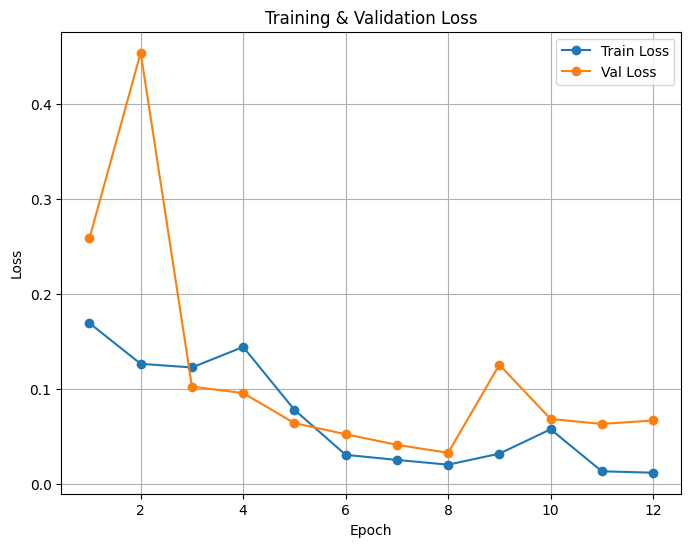

In [21]:
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, EPOCHS+1), val_losses, label='Val Loss', marker='o')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(OUT_DIR/"loss_curve.png", dpi=300)
plt.show()


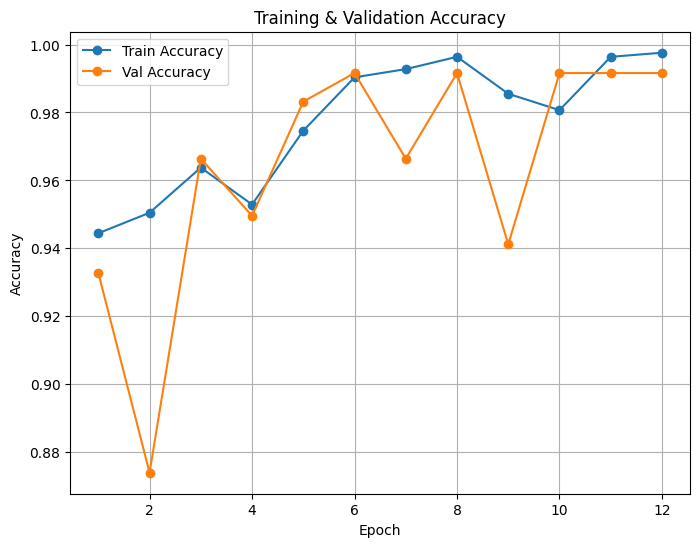

In [22]:
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, EPOCHS+1), val_accs, label='Val Accuracy', marker='o')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(OUT_DIR/"accuracy_curve.png", dpi=300)
plt.show()


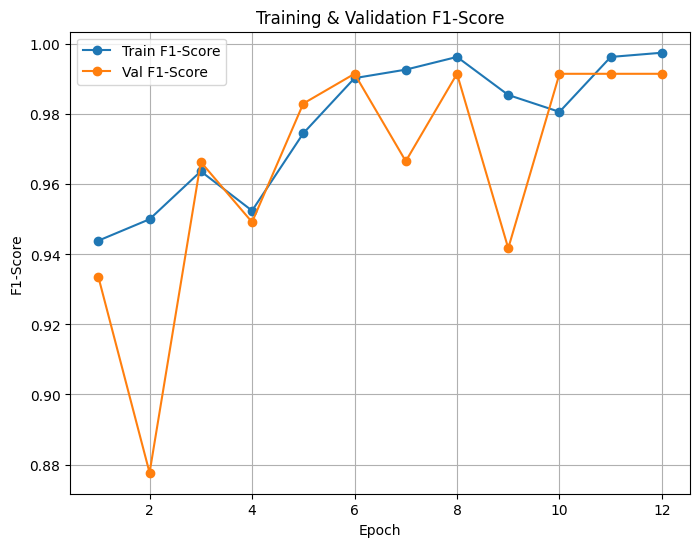

In [23]:
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_f1s, label='Train F1-Score', marker='o')
plt.plot(range(1, EPOCHS+1), val_f1s, label='Val F1-Score', marker='o')
plt.title("Training & Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True)
plt.savefig(OUT_DIR/"f1_curve.png", dpi=300)
plt.show()


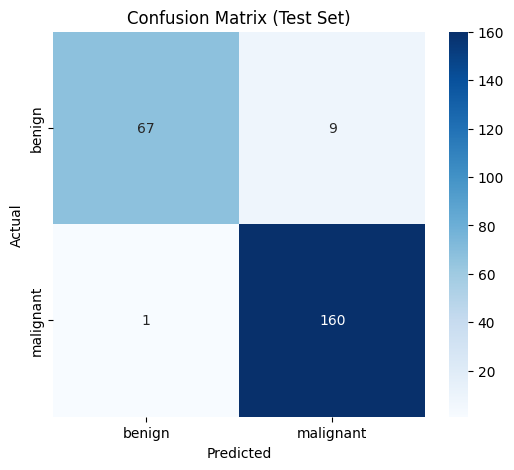

In [24]:
# load best model
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(OUT_DIR/"confusion_matrix.png", dpi=300)
plt.show()
